# QSVM for AdHoc Dataset
## Prepare data

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import Aer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
from qiskit.providers.ibmq import least_busy
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel, FidelityQuantumKernel
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('datasets/adhoc_100.csv', index_col=0)
df

,feature_1,feature_2,label
0,2.953097,2.324779,0.0
1,1.382301,4.021239,0.0
2,5.592035,5.152212,0.0
3,4.084070,1.130973,0.0
4,5.906194,2.827433,0.0
...,...,...,...
95,3.581416,1.822124,1.0
96,4.963716,1.130973,1.0
97,5.215044,4.712389,1.0
98,4.586725,2.324779,1.0


In [3]:
feature_dimension = df.shape[1] - 1
print(f"Feature dimension: {feature_dimension}")

Feature dimension: 2


In [4]:
# Split the data into training and test sets
all_features = df.copy()
all_labels = all_features.pop('label')

train = df.sample(frac=0.75, random_state=42)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

## Find best SVM setting

Try different kernels with different settings and plot the winning circuit

In [5]:
algorithm_globals.random_seed = 42
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [7]:
# Specify kernel experiments:

kernels = [
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=3, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=4, entanglement='linear')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='sca')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='sca')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=3, entanglement='sca')),
                  quantum_instance=quantum_instance),
    QuantumKernel(feature_map=(ZZFeatureMap(feature_dimension=feature_dimension, reps=4, entanglement='sca')),
                  quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['ZZ']),
    #               quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['Z', 'XX']),
    #               quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear', paulis=['ZZ']),
    #               quantum_instance=quantum_instance),
    # QuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear', paulis=['Z', 'XX']),
    #               quantum_instance=quantum_instance),
    # FidelityQuantumKernel(feature_map=ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear'),
    #                       fidelity=ComputeUncompute(sampler=Sampler())),
    # FidelityQuantumKernel(feature_map=ZZFeatureMap(feature_dimension=feature_dimension, reps=3, entanglement='linear'),
    #                       fidelity=ComputeUncompute(sampler=Sampler())),
    # FidelityQuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['Z', 'XX']),
    #                       fidelity=ComputeUncompute(sampler=Sampler())),
    # FidelityQuantumKernel(feature_map=PauliFeatureMap(feature_dimension=feature_dimension, reps=1, entanglement='linear', paulis=['Z', 'XX']),
    #                       fidelity=ComputeUncompute(sampler=Sampler()))
]

In [27]:
svc = SVC(C=0.001)
search = RandomizedSearchCV(svc, cv=10, n_iter=16, n_jobs=-1, refit=True,
                            param_distributions={'kernel': [kernel.evaluate for kernel in kernels]})
# search.fit(train_features, train_labels)
search.fit(all_features, all_labels)

/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=16. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


RandomizedSearchCV(cv=10, estimator=SVC(C=0.001), n_iter=16, n_jobs=-1,
                   param_distributions={'kernel': [<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x2adbb8a90>>,
                                                   <bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x2ab8d79a0>>,
                                                   <bound method Q...
                                                   <bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x2ad6c87c0>>,
                                                   <bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x2ae5a9dc0>>,
                                                   <bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x2ae0cedc0>>]})

Best is kernel 1 using ZZFeatureMap with 2 reps and linear entanglement


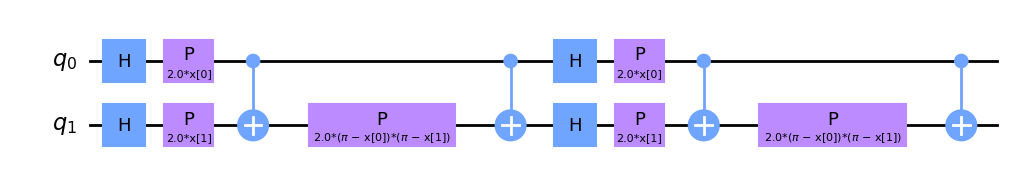

In [28]:
best_kernel = search.best_params_['kernel'].__self__
print(f"Best is kernel {kernels.index(best_kernel)} using {best_kernel.feature_map.__class__.__name__} with {best_kernel.feature_map.reps} reps and {best_kernel.feature_map.entanglement} entanglement")
svc = search.best_estimator_
best_kernel.feature_map.decompose().draw(output='mpl')

## Train the winning kernel circuit using 10-fold cross validation

In [10]:
best_kernel = kernels[1] # Index from output above
svc = SVC(C=0.001, kernel=best_kernel.evaluate)

results = cross_validate(svc, train_features, train_labels, cv=10, n_jobs=-1, return_estimator=True, return_train_score=True)

/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy

In [15]:
resulting_models = results['estimator']
total_times = results['fit_time'] + results['score_time']
print(f"Time consumed for each SVC: {total_times}")

[6.07705212 6.14042282 6.18982506 6.11933184 6.1201129  5.96835804
 6.10111833 6.26538587 6.30280209 6.20223498]


In [16]:
# Calculate accuracy on testing dataset

accuracies = [model.score(test_features, test_labels) for model in resulting_models]

/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/l

Accuracies: [0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36]


{'whiskers': [<matplotlib.lines.Line2D at 0x2a1a1b220>,
 'caps': [<matplotlib.lines.Line2D at 0x2a1a1b7c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a1a26fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x2a1a1bd60>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a1a1e070>],
 'means': []}

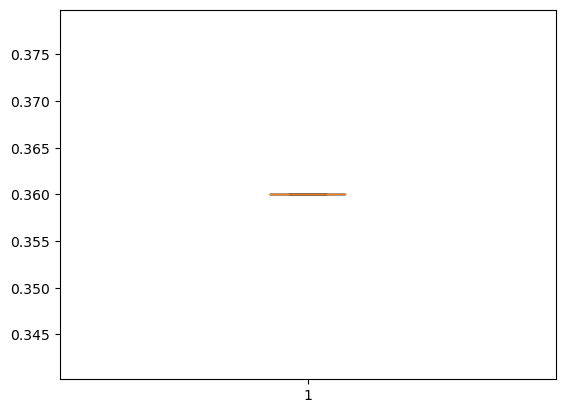

In [20]:
print(f"Accuracies: {accuracies}")
plt.boxplot(accuracies)

---
### Classical Implementation

In [23]:
classical_svc = SVC(C=0.001)
classical_results = cross_validate(classical_svc, train_features, train_labels, cv=10, n_jobs=-1, return_estimator=True, return_train_score=True)
classical_results

{'fit_time': array([0.00149894, 0.00092411, 0.00145102, 0.00132108, 0.00080466,
        0.00086284, 0.00112009, 0.00089812, 0.00079703, 0.00079417]),
 'score_time': array([0.00063086, 0.00054884, 0.00067306, 0.00056863, 0.00049019,
        0.00050116, 0.00062394, 0.00049591, 0.00048685, 0.00049806]),
 'estimator': [SVC(C=0.001),
  SVC(C=0.001),
  SVC(C=0.001),
  SVC(C=0.001),
  SVC(C=0.001),
  SVC(C=0.001),
  SVC(C=0.001),
  SVC(C=0.001),
  SVC(C=0.001),
  SVC(C=0.001)],
 'test_score': array([0.5       , 0.5       , 0.5       , 0.5       , 0.625     ,
        0.57142857, 0.57142857, 0.57142857, 0.57142857, 0.57142857]),
 'train_score': array([0.55223881, 0.55223881, 0.55223881, 0.55223881, 0.53731343,
        0.54411765, 0.54411765, 0.54411765, 0.54411765, 0.54411765])}

In [25]:
print(f"Classical mean SVC score: {classical_results['test_score'].mean()} with std. deviation {classical_results['test_score'].std()}")

Classical mean SVC score: 0.5482142857142857 with std. deviation 0.042295426008310745


In [31]:
classical_scores = np.array([model.score(test_features, test_labels) for model in classical_results['estimator']])
print(classical_scores)

[0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36 0.36]


In [32]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (classical_scores.mean(), classical_scores.std()))

0.36 accuracy with a standard deviation of 0.00


---
### Run on real quantum computer

In [88]:
from qiskit import IBMQ

# Best kernel should already be evaluated and set (in the above code cell)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='zhaw-1')
backend = least_busy(provider.backends(simulator=False))
print(f"Chosen backend: {backend}")
best_kernel.quantum_instance = QuantumInstance(backend, shots=1024)
score = svc.score(test_features, test_labels)
print(f"Quantum score: {score}")


ibmqfactory.load_account:WARNING:2023-01-09 10:37:43,905: Credentials are already in use. The existing account in the session will be replaced.


KeyboardInterrupt: 